# Building Logistic Regression Model for Sentiment Analysis

Building a logistic regression model for sentiment analysis on the sample twitter dataset from NLTK

[**1. Preprocessing**](#1.-Preprocessing)

[**2. Model Building**](#2.-Model-Building)

[**3. Training the Model**](#3.-Training-the-Model)

[**4. Predicting and Evaluation**](#4.-Predicting-and-Evaluation)


## 1. Preprocessing

### 1.1. Initializing

In [1]:
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import TweetTokenizer
import random
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Mahmoud\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mahmoud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
postw = twitter_samples.strings('positive_tweets.json')
negtw = twitter_samples.strings('negative_tweets.json')
print('Number of positive tweets: ', len(postw))
print('Number of negative tweets: ', len(negtw))

Number of positive tweets:  5000
Number of negative tweets:  5000


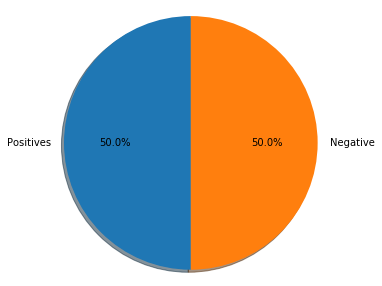

In [4]:
fig = plt.figure(figsize=(5, 5))
labels = 'Positives', 'Negative'
sizes = [len(postw), len(negtw)] 
plt.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')  
plt.show()

Spliting the data into train and test:

In [5]:
test_pos = postw[4000:]
train_pos = postw[:4000]
test_neg = negtw[4000:]
train_neg = negtw[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

Creating labels:

In [6]:
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


### 1.2. Tweet processing

Defining tweet processing function.

**Input**: a string containing a tweet  
**Output**: a list of words containing the processed tweet

In [7]:
def process_tweet(tweet):
    
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # removing hyperlinks, Twitter marks and styles
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    # tokenizing tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    # removing stop words and punctuations, stemming
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation):  
            stem_word = stemmer.stem(word) 
            tweets_clean.append(stem_word)

    return tweets_clean

### 1.3. Building word frequencies

Defining building word frequencies function.

**Input**: a list of tweets, an m x 1 array with the sentiment label of each tweet (either 0 or 1)  
**Output**: a dictionary mapping each (word, sentiment) pair to its frequency

In [8]:
def build_freqs(tweets, ys):

    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1

    return freqs

Creating frequency dictionary:

In [9]:
freqs = build_freqs(train_x, train_y)
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11346


## 2. Model Building

### 2.1. Sigmoid function

In [10]:
def sigmoid(z):
    
    s = 1/(1+np.exp(-z))
        
    return s

### 2.2. Defining gradient descent function

**Input**: matrix of features which is (m,n+1), corresponding labels of the input matrix x, dimensions (m,1), weight vector of dimension (n+1,1), learning rate, number of iterations  
**Output**: the final cost, final weight vector

In [11]:
def gradientDescent(x, y, theta, alpha, num_iters):

    m = np.shape(x)[0]

    for i in range(0, num_iters):
        z = np.dot(x,theta)
        h = sigmoid(z)
        J = (-1/m)*(np.dot(y.T,np.log(h))+np.dot((1-y).T,np.log(1-h)))
        theta = theta - (alpha/m)*np.dot(x.T,(h-y))

    J = float(J)
    return J, theta

## 3. Training the Model

### 3.1. Extracting the features

**Input**: a list of words for one tweet, a dictionary corresponding to the frequencies of each tuple (word, label)  
**Output**: a feature vector of dimension (1,3)

In [12]:
def extract_features(tweet, freqs):

    word_l = process_tweet(tweet)
    x = np.zeros((1, 3)) 
    x[0,0] = 1 

    for word in word_l:
        x[0,1] += freqs.get((word, 1.0),0)
        x[0,2] += freqs.get((word, 0.0),0)

    assert(x.shape == (1, 3))
    return x

### 3.2. Training the model

In [13]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

Y = train_y

J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.24216529.
The resulting vector of weights is [7e-08, 0.0005239, -0.00055517]


## 4. Predicting and Evaluation

Defining prediction function

**Input**: a string, a dictionary corresponding to the frequencies of each tuple (word, label), (3,1) vector of weights  
**Output**: the probability of a tweet being positive or negative

In [14]:
def predict_tweet(tweet, freqs, theta):

    x = extract_features(tweet, freqs)
    y_pred = sigmoid(np.dot(x,theta))

    return y_pred

Defining accuracy calculator function

**Input**: a list of tweets, (m, 1) vector with the corresponding labels for the tweets, a dictionary with the frequency of each pair (or tuple), weight vector of dimension (3, 1)  
**Output**: accuracy: (# of tweets classified correctly) / (total # of tweets)

In [15]:
def test_logistic_regression(test_x, test_y, freqs, theta):

    m = np.shape(np.array(test_y))[0]
    y_hat = []
    
    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs, theta)
        if y_pred > 0.5:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)

    y_hat = np.array(y_hat)
    test_y = np.squeeze(test_y)
    accuracy = sum((y_hat==test_y).astype(int))/m

    return accuracy

Evaluating the model performance on test set:

In [16]:
accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {accuracy:.4f}")

Logistic regression model's accuracy = 0.9950
